In [ ]:
# !pip install --upgrade --force-reinstall torch torchvision torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 98.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 108.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 90.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.3/133.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 23.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
 

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset
from PIL import Image, UnidentifiedImageError
import os

In [ ]:
# 드라이브에서 데이터 가져오기
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 하이퍼파라미터 설정
dataroot = '/content/drive/My Drive/ai/'
batch_size = 128
image_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

num_epochs = 5
lr = 0.0002
beta1 = 0.5
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

# 이미지 전처리
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
# 커스텀 데이터셋 클래스 정의
class CustomImageFolder(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.samples = []
        for (dirpath, _, filenames) in os.walk(root):
            for filename in filenames:
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.samples.append(os.path.join(dirpath, filename))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        path = self.samples[index]
        try:
            with open(path, 'rb') as f:
                img = Image.open(f)
                img = img.convert('RGB')
                if self.transform:
                    img = self.transform(img)
                return img
        #에러 발생 시 다음 이미지로 넘어가는 방식으로 오류 처리
        except UnidentifiedImageError:
            print(f"UnidentifiedImageError: cannot identify image file {path}")
            # 재귀적으로 다음 이미지로 가
            return self.__getitem__((index + 1) % len(self.samples))

In [ ]:
# 데이터셋 로드
train_dataset = CustomImageFolder(root=dataroot + 'training_set', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CustomImageFolder(root=dataroot + 'validation_set', transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


UnidentifiedImageError: cannot identify image file /content/drive/My Drive/ai/training_set/painting/1025.jpg
UnidentifiedImageError: cannot identify image file /content/drive/My Drive/ai/training_set/painting/1075.jpg


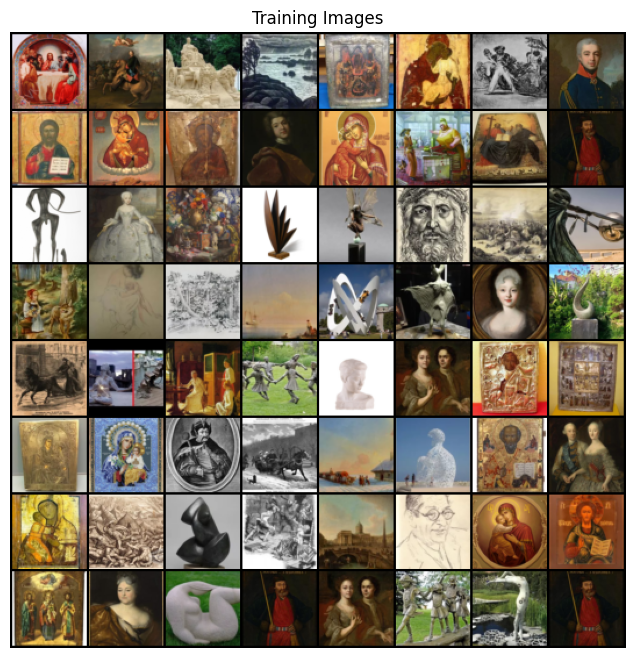

In [ ]:
# 데이터 시각화
real_batch = next(iter(train_dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,device)
    def __len__(self):
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [ ]:
# 데이터셋 로드
dataset = CustomImageFolder(root=dataroot, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)